In [1]:
import RES.RESources as RES
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

 └> Using CODERS API key: w0OksqQKMFMtKPbO


In [2]:
from RES.hdf5_handler import DataHandler
import RES.visuals as vis
store=f"data/store/resources_BC.h5"
datahandler=DataHandler(store)
cells=datahandler.from_store('cells')
boundary=datahandler.from_store('boundary')

<Axes: >

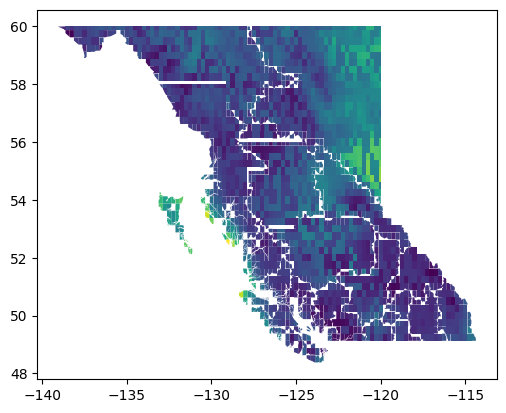

In [3]:
cells.plot('windspeed_ERA5')

# Set Required Args to Activate Modules

In [6]:
import RES.RESources as RES
import pandas as pd
import geopandas as gpd

# Iterate over provinces for both solar and wind resources
resource_types = ['wind','solar']  #
countries=['BC'] 
for country in countries:
    for resource_type in resource_types:
        required_args = {
            "config_file_path": 'config/config.yaml',
            # "region_short_code": country,
            "resource_type": resource_type
        }
        
        # Create an instance of Resources and execute the module
        RES_module = RES.RESources_builder(**required_args)
        # RES_module.build(select_top_sites=True,
        #                  use_pypsa_buses=False)
        

2025-05-31 06:36:07,638 - INFO - Directory 'data/downloaded_data/NREL/ATB/ATBe.parquet' found locally.


____________________________________________________________
     Initiating RESource Builder...
____________________________________________________________
 └> NREL_ATBProcessor initiated...
  └> Processing Annual Technology Baseline (ATB) data sourced from NREL...
  └> ATB cost datafile: ATBe.parquet loaded
  └> Extracting technology baseline costs...
  └─> Extracting Solar PV technology cost...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cost/atb/solar'
  └─> Extracting Wind Turbine technology cost...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cost/atb/wind'
  └─> Extracting BESS technology cost...


2025-05-31 06:36:08,163 - INFO - Directory 'data/downloaded_data/NREL/ATB/ATBe.parquet' found locally.


>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cost/atb/bess'
 └> Snapshot for Resources: 2023-01-01 07:00:00 to 2024-01-01 06:00:00
____________________________________________________________
     Initiating RESource Builder...
____________________________________________________________
 └> NREL_ATBProcessor initiated...
  └> Processing Annual Technology Baseline (ATB) data sourced from NREL...
  └> ATB cost datafile: ATBe.parquet loaded
  └> Extracting technology baseline costs...
  └─> Extracting Solar PV technology cost...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cost/atb/solar'
  └─> Extracting Wind Turbine technology cost...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cost/atb/wind'
  └─> Extracting BESS technology cost...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cost/atb/bess'
 └> Snapshot for Resources: 2023-01-01 07:00:00 to 2024-01-0

In [7]:
lines=gpd.read_file('data/downloaded_data/OSM/BC_power.geojson')

In [8]:
# from RES.power_nodes import GridNodeLocator

# power_nodes = GridNodeLocator(**required_args)

# lines = power_nodes.get_OSM_grid_lines()
# # lines_filtered = lines[~(lines['voltage'] == '400000')]
# # lines_filtered = lines_filtered[~(lines_filtered['voltage'] == '400')]

In [9]:
# import geopandas as gpd
# from shapely.geometry import Point, LineString

# # Filter only LineString geometries
# lines = lines[lines.geometry.type == "LineString"].copy()
# lines = lines.set_geometry("geometry")
# lines.crs = cells.crs

# # Create centroid column once
# cells["centroid"] = cells.apply(lambda row: Point(row["x"], row["y"]), axis=1)

In [10]:
from shapely.geometry import LineString, MultiLineString
from shapely.ops import nearest_points

def filter_lineal_geometries(geom):
    """
    Ensure the result of intersection is a LineString or MultiLineString.
    Handles GeometryCollections recursively.
    """
    if geom.is_empty:
        return None
    elif geom.geom_type in ["LineString", "MultiLineString"]:
        return geom
    elif geom.geom_type == "GeometryCollection":
        lines = [g for g in geom.geoms if g.geom_type in ["LineString", "MultiLineString"]]
        if lines:
            return lines[0] if len(lines) == 1 else MultiLineString(lines)
    return None

def find_nearest_single_connection_point(cell_centroid, cell_geometry, cell_gdf, line_gdf):
    # Keep only valid lineal geometries
    line_gdf = line_gdf[line_gdf.geometry.geom_type.isin(["LineString", "MultiLineString"])]

    # 1. Try to find lines intersecting this cell
    intersecting_lines = line_gdf[line_gdf.geometry.intersects(cell_geometry)].copy()

    if not intersecting_lines.empty:
        # Clip to the cell geometry
        intersecting_lines["geometry"] = intersecting_lines.geometry.intersection(cell_geometry)
    else:
        # 2. Find nearest neighbor with intersecting lines
        candidate_cells = cell_gdf[cell_gdf.geometry.apply(
            lambda geom: not line_gdf[line_gdf.geometry.intersects(geom)].empty
        )].copy()

        candidate_cells["distance"] = candidate_cells.geometry.centroid.distance(cell_centroid)
        nearest_cell = candidate_cells.loc[candidate_cells["distance"].idxmin()]

        # Intersect that cell's geometry
        cell_geom = nearest_cell.geometry
        intersecting_lines = line_gdf[line_gdf.geometry.intersects(cell_geom)].copy()
        intersecting_lines["geometry"] = intersecting_lines.geometry.intersection(cell_geom)

    # 3. Clean geometries: keep only valid line geometries
    intersecting_lines["geometry"] = intersecting_lines.geometry.apply(filter_lineal_geometries)
    intersecting_lines = intersecting_lines[intersecting_lines.geometry.notnull()]

    if intersecting_lines.empty:
        return None, float("inf")  # or handle gracefully

    # 4. Find the nearest point on the lines
    distances = intersecting_lines.geometry.apply(lambda line: cell_centroid.distance(line))
    nearest_geom = intersecting_lines.loc[distances.idxmin(), "geometry"]

    nearest_point = nearest_geom.interpolate(nearest_geom.project(cell_centroid))
    distance = cell_centroid.distance(nearest_point)
    cell_gdf["has_line"] = cell_gdf.geometry.apply(
        lambda geom: not line_gdf[line_gdf.geometry.intersects(geom)].empty
    )

    return nearest_point, distance


In [11]:
lines=lines[lines['element']=='way']
lines=lines[lines['voltage'].notna()]

In [12]:
# Split the 'voltage' column into multiple columns
voltage_split = lines['voltage'].str.split(';', expand=True)

# Rename the columns to voltage1, voltage2, etc.
voltage_split.columns = [f'voltage{i+1}' for i in range(voltage_split.shape[1])]

# Concatenate the new columns with the original DataFrame
lines = pd.concat([lines, voltage_split], axis=1)
# Ensure the 'voltage' column exists and contains data
if 'voltage' in lines.columns and lines['voltage'].notna().any():
    # Ensure 'voltage' is treated as string before splitting
    voltage_split = lines['voltage'].astype(str).str.split(';', expand=True)

    # Convert all split values to numeric, coerce errors to NaN
    voltage_split = voltage_split.apply(pd.to_numeric, errors='coerce')

    # Assign the max voltage per row
    lines['max_voltage'] = voltage_split.max(axis=1)

    # Rename and concatenate the voltage columns
    voltage_split.columns = [f'voltage_{i+1}' for i in range(voltage_split.shape[1])]
    lines = pd.concat([lines, voltage_split], axis=1)
else:
    print("The 'voltage' column is missing or empty in the DataFrame.")


<Axes: >

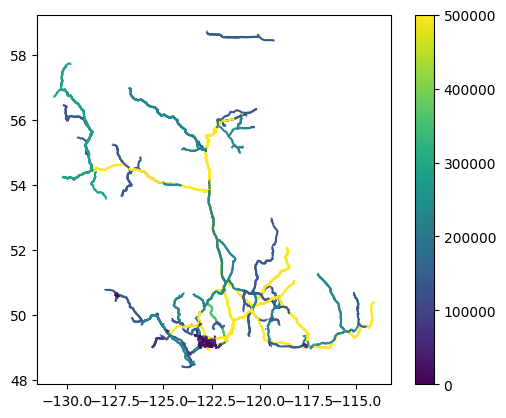

In [13]:
lines.plot('max_voltage',legend=True)

In [ ]:
# Ensure centroid is prepared once
from shapely import Point
lines=lines[lines['max_voltage']>=11000]

cells["centroid"] = cells.apply(lambda row: Point(row["x"], row["y"]), axis=1)

# Apply to each row to compute the single connection point
cells[["nearest_connection_point", "nearest_distance"]] = cells.apply(
    lambda row: find_nearest_single_connection_point(row["centroid"], row["geometry"], cells,lines),
    axis=1, result_type="expand"
)

In [ ]:
cells["has_line"] = cells.geometry.apply(
        lambda geom: not lines[lines.geometry.intersects(geom)].empty
    )

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe

# Assuming 'data' and 'cells' are already loaded
data = lines

# Ensure valid geometries
cells = cells[cells.is_valid]
data = data[data.is_valid]

# Setup colormap based on voltage
unique_voltages = sorted(data['max_voltage'].dropna().unique())
cmap = cm.get_cmap('tab10', len(unique_voltages))
color_map = dict(zip(unique_voltages, cmap.colors))

# Split cells
cells_with_line = cells[cells["has_line"] == True]
cells_without_line = cells[cells["has_line"] == False]

# Plot setup
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_facecolor("white")

# Plot cells with and without lines
cells_with_line.plot(ax=ax, color="lightcoral", edgecolor="white", alpha=0.3, linewidth=0.5)
cells_without_line.plot(ax=ax, color="grey", edgecolor="white", alpha=0.2, linewidth=0.5)

# Plot nearest connection points with glow effect
# cells.set_geometry("nearest_connection_point").plot(
#     ax=ax, 
#     color='red', 
#     markersize=10, 
#     alpha=0.8, 
#     label="Within Grid Nearest line points",
#     path_effects=[pe.withStroke(linewidth=1, foreground="yellow", alpha=1)]
# )

# Plot voltage-based line data
for voltage_level in unique_voltages:
    subset = data[data['max_voltage'] == voltage_level]
    subset.plot(
        ax=ax,
        color=color_map[voltage_level],
        markersize=20,
        label=f'Line (kV): {voltage_level/1E3}',
        alpha=0.5,
        edgecolor='white',
        linewidth=2
    )

# Optional: Add basemap
# ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=1, crs=cells.crs)

# Final plot styling
ax.set_title("British Columbia", fontsize=16, fontweight='bold', pad=15)
ax.axis("off")

# Manually adding the legend for cells with and without lines
from matplotlib.lines import Line2D

# Create custom legend handles
legend_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=10, alpha=0.6,label='Cells with Line'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='lightcoral', markersize=10, alpha=0.6,label='Cells without Line')
]

# Combine custom legend with other handles
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(legend_handles + list(by_label.values()), 
          ['Cells with Line', 'Cells without Line'] + list(by_label.keys()), 
          loc='upper left', bbox_to_anchor=(1.0, 1), frameon=False, fontsize=9)

plt.tight_layout()
plt.show()


NameError: name 'lines' is not defined

In [ ]:
plt.savefig('Lines_BC.png',dpi=600,transparent=True)

<Figure size 640x480 with 0 Axes>

In [ ]:
# RES_module.datahandler.to_store(RES_module.gridcells.resource_grid_cells,'cells')

In [ ]:
# RES_module.gridcells.resource_grid_cells

In [ ]:
# datahandler.from_store('cells')

In [ ]:
RES_module.gridcells.region_boundary

AttributeError: 'GridCells' object has no attribute 'region_boundary'

In [ ]:
A=RES_module.find_grid_nodes()

In [ ]:
# RES_module.build()

In [ ]:
cells=datahandler.from_store('cells')
boundary=datahandler.from_store('boundary')
solar_clusters=datahandler.from_store('clusters/solar')
wind_clusters=datahandler.from_store('clusters/wind')
solar_clusters_ts=datahandler.from_store('timeseries/clusters/solar')
wind_clusters_ts=datahandler.from_store('timeseries/clusters/wind')

In [ ]:
resource_clusters_solar,cluster_timeseries_solar=RES_module.select_top_sites(solar_clusters,
                                                                solar_clusters_ts,
                                                                    resource_max_capacity=10)

resource_clusters_wind,cluster_timeseries_solar=RES_module.select_top_sites(wind_clusters,
                                                                wind_clusters_ts,
                                                                    resource_max_capacity=20)

In [ ]:
# resource_clusters_solar.plot('potential_capacity',legend=True)
# resource_clusters_wind.plot('potential_capacity',legend=True)

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
legend_x_ax_offset=1
# Ensure 'Region' is in the columns for both boundary and cells
if 'Region' not in boundary.columns:
    boundary = boundary.reset_index(inplace=True)

# Assign a number to each region
boundary['Region_Number'] = range(1, len(boundary) + 1)

# Define custom bins and labels for solar and wind capacity
solar_bins = [0, 100, 200, 300, 500, float('inf')]  # Custom ranges
solar_labels = ['<100','100-200', '200-300', '300-500','>500']  # Labels for legend

# Define custom bins and labels for solar and wind capacity
wind_bins = [0, 300, 500, 1000, 2000,3000, float('inf')]  # Custom ranges
wind_labels = ['<300','300-500', '500-1000', '1000-2000','2000-3000', '>3000']  # Labels for legend

# Categorize potential_capacity_solar and potential_capacity_wind into bins
resource_clusters_solar['solar_category'] = pd.cut(resource_clusters_solar['potential_capacity'], bins=solar_bins, labels=solar_labels, include_lowest=True)
resource_clusters_wind['wind_category'] = pd.cut(resource_clusters_wind['potential_capacity'], bins=wind_bins, labels=wind_labels, include_lowest=True)

# Create figure and axes for side-by-side plotting
fig, (ax1, ax2) = plt.subplots(figsize=(18, 8), ncols=2)
fig.suptitle("Potential Sites for Targeted Capacity Investments", fontsize=16,weight='bold')
# Set axis off for both subplots
ax1.set_axis_off()
ax2.set_axis_off()

# Shadow effect offset
shadow_offset = 0.01

# Plot solar map on ax1
# Add shadow effect for solar map
boundary.geometry = boundary.geometry.translate(xoff=shadow_offset, yoff=-shadow_offset)
boundary.plot(ax=ax1, color='None', edgecolor='grey', linewidth=1, alpha=0.7)  # Shadow layer
boundary.geometry = boundary.geometry.translate(xoff=-shadow_offset, yoff=shadow_offset)

# Plot solar cells
resource_clusters_solar.plot(column='solar_category', ax=ax1, cmap='Wistia', legend=True, 
           legend_kwds={'title': "Solar Capacity (MW)", 'loc': 'upper right','bbox_to_anchor':(legend_x_ax_offset,1), 'frameon': False})

# Plot actual boundary for solar map
boundary.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.2, alpha=0.7)
"""
# Annotate region numbers for solar map
for idx, row in boundary.iterrows():
    centroid = row.geometry.centroid
    ax1.annotate(f"{row['Region_Number']}", 
                 xy=(centroid.x, centroid.y), 
                 ha='center', va='center',
                 fontsize=7, color='black',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2'))
"""
# Plot wind map on ax2
# Add shadow effect for wind map
boundary.geometry = boundary.geometry.translate(xoff=shadow_offset, yoff=-shadow_offset)
boundary.plot(ax=ax2, color='None', edgecolor='grey', linewidth=1, alpha=0.7)  # Shadow layer
boundary.geometry = boundary.geometry.translate(xoff=-shadow_offset, yoff=shadow_offset)

# Plot wind cells
resource_clusters_wind.plot(column='wind_category', ax=ax2, cmap='summer', legend=True, 
           legend_kwds={'title': "Wind Capacity (MW)", 'bbox_to_anchor':(legend_x_ax_offset,1), 'frameon': False})

# Plot actual boundary for wind map
boundary.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.2, alpha=0.7)
"""
# Annotate region numbers for wind map
for idx, row in boundary.iterrows():
    centroid = row.geometry.centroid
    ax2.annotate(f"{row['Region_Number']}", 
                 xy=(centroid.x, centroid.y), 
                 ha='center', va='center',
                 fontsize=8, color='black',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2'))
"""
# Adjust layout for cleaner appearance
fig.patch.set_alpha(0)  # Make figure background transparent
plt.tight_layout()

# Show the side-by-side plot

# plt.savefig('solar_wind_capacity_map.png',dpi=300)
plt.show()

In [ ]:
resource_clusters_wind.plot(column='potential_capacity',cmap='summer', legend=True,)